/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/3250293794.py:247: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2
/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/3250293794.py:251: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)
/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/3250293794.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure y

[0.]
0.0 0.0 0.0 0.0 0.0 0.0
[300.030003]
15.757082495403868 12.13852294201639 9.230764122491081 6.541158807768854 8.664756794852705 11.33137678008021
[600.060006]
35.4341297056833 29.57840334091416 24.53292662727876 18.55790601333152 22.491451634486676 27.085717221695244
[900.090009]
40.480554257197845 36.46348308683955 32.59576043568483 26.268535421523794 29.617263074447422 33.14800457580457
[1200.120012]
42.225558278994505 38.923398396738165 35.7002986949556 29.853313693324385 32.75504085523173 35.76222518845382
[1500.150015]
43.24783789477393 40.37123112540457 37.54597742398125 32.13465783722103 34.733713060688835 37.404681030700615
[1800.180018]
43.94514761007438 41.36103947566056 38.813832106526675 33.76538134925358 36.14162020462956 38.571183396859986
[2100.210021]
44.46124569578196 42.09462158048198 39.7561971642773 35.010391063986866 37.21347481717265 39.45822693630468
[2400.240024]
44.86360914888081 42.66706848645403 40.49299848810057 36.00299395383062 38.06636354803574 40.16

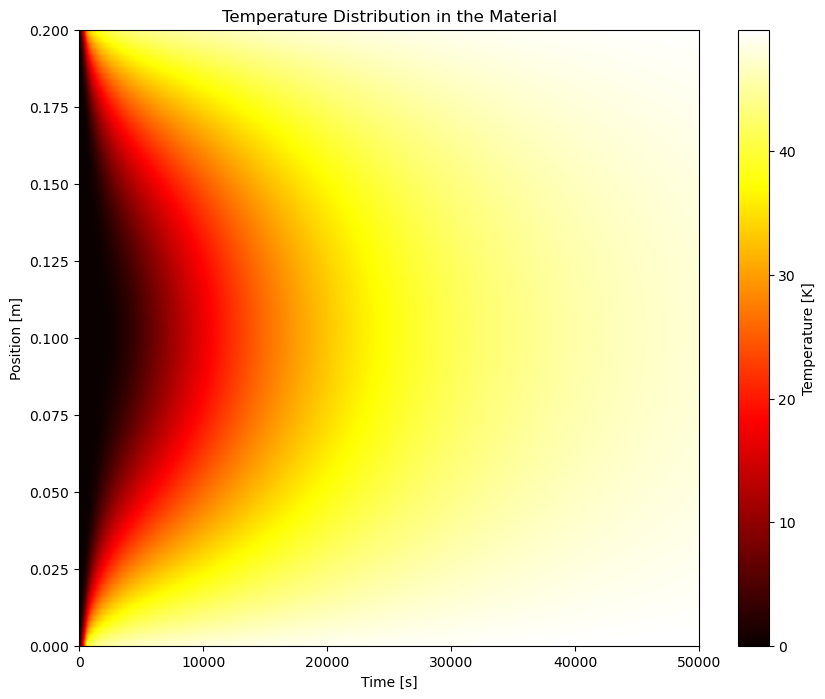

(100, 2) (100, 1) (30100, 2)
Iter 100, Loss: 1.58442e+02, Loss_u: 1.66102e+01, Loss_f: 2.83319e-04
Iter 200, Loss: 6.36981e+01, Loss_u: 1.23786e+01, Loss_f: 6.41436e-04
Iter 300, Loss: 5.27595e+01, Loss_u: 1.74516e+01, Loss_f: 4.23956e-04
Iter 400, Loss: 4.23824e+01, Loss_u: 2.94365e+01, Loss_f: 1.80406e-04
Iter 500, Loss: 4.22863e+01, Loss_u: 2.89011e+01, Loss_f: 1.14528e-04
Error u: 4.374252e-01


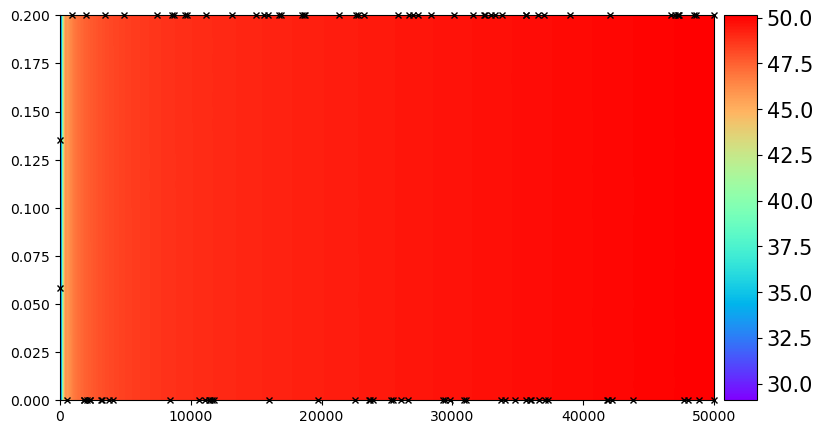

In [11]:
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDAのサポート
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# ネットワーク構造の定義
#TODO1:熱伝達方程式の解に対応したネットワーク構造を定義
#TODO2:対流熱伝達係数を入力に受け取るようにネットワーク構造を変更
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # パラメータ
        self.depth = len(layers) - 1
        
        # レイヤー順序の設定
        self.activation = torch.nn.ELU
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        # レイヤーの展開
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

# 物理インフォームドニューラルネットワーク（PINN）の定義
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, k, rho, cp, alpha, h1, h2, T_inf):
        
        # 境界条件
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # データ
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        #新しく追加
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2
        self.T_inf = T_inf
        # self.lambda0 = lambda0
        # self.lambda1 = lambda1
        # self.lambda2 = lambda2
        
        # 深層ニューラルネットワーク
        self.dnn = DNN(layers).to(device)
        
        # オプティマイザー: 同じ設定を使用
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    #熱伝導方程式の残差を計算
    def net_f(self, x, t):
        """ PyTorchのautogradを用いて残差を計算 """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - self.alpha * u_xx
        return f
    
    #追加：境界条件の残差①を計算
    def net_BC1(self, x, t):
        """ 境界条件の残差を計算 """
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC1 = self.T_inf - u + (self.k / self.h1) * u_x
        return BC1

    #追加：境界条件の残差②を計算
    def net_BC2(self, x, t):
        """ 境界条件の残差を計算 """
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC2 = self.T_inf - u - (self.k / self.h2) * u_x
        return BC2
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)

        #追加:境界条件の予測
        BC1_pred = self.net_BC1(self.x_u, self.t_u) # 境界条件1の誤差を計算
        BC2_pred = self.net_BC2(self.x_u, self.t_u) # 境界条件2の誤差を計算

        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        #追加:境界条件の誤差
        loss_BC1 = torch.mean(BC1_pred ** 2)
        loss_BC2 = torch.mean(BC2_pred ** 2)
        
        #TODO3:損失関数のに重み付けを追加
        # loss = (1 / len(f_pred)) * loss_f + self.lambda0 * loss_u + self.lambda1 * loss_BC1 + self.lambda2 * loss_BC2
        loss = loss_u + loss_f + loss_BC1 + loss_BC2
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # 逆伝播と最適化
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# k = 0.01  # 熱伝達係数
# alpha=0.01 # 熱拡散係数
K = 0.47 #部品の熱伝導率。[W/mK]
rho = 1573 #部品の密度。[kg/m^3]
cp = 967 #部品の比熱。[J/kgK]
alpha = K / (rho * cp)
# noise = 0.0

h1 = 100
h2 = 50
T_inf = 50

#TODO4：損失関数の重み付け
#lambda0, lambda1, lambda2 = 1.0, 1.0, 1.0 

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

#元コード
# データの読み込み
#data = scipy.io.loadmat('data/heat_conduction.mat')

# t = data['t'].flatten()[:,None]
# x = data['x'].flatten()[:,None]
# 初期条件/境界条件の解
# Exact = np.real(data['usol']).T

# 最優先TODO：初期条件/境界条件の解を計算
x = np.linspace(0, 0.2, 100)[:, None]  # 空間グリッド
t = np.linspace(0, 50000, 10000)[:, None]  # 時間グリッド
dx = x[1] - x[0]  # 空間ステップ
dt = t[1] - t[0]  # 時間ステップ

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    # print(T_ext1, T_ext2)
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    # 境界条件の適用
    # 左端の対流境界条件
    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)

    # 右端の対流境界条件
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)
    # if n % 100 == 0:
    if n % 60 == 0:
        print(t[n])
        print(u[n + 1, 0], u[n + 1, 1], u[n + 1, 2], u[n + 1, -3], u[n + 1, -2], u[n + 1, -1])

# 結果のプロット
plt.figure(figsize=(10, 8))
plt.imshow(u.T, extent=[0, 50000, 0, 0.2], aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label='Temperature [K]')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Temperature Distribution in the Material')
plt.show()

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
# u_star = Exact.flatten()[:,None]
u_star = u.flatten()[:,None]           

# ドメインの境界
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = u[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = u[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = u[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]
print(X_u_train.shape, u_train.shape, X_f_train.shape)
# モデルのインスタンス化
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, rho, cp, K, h1, h2, T_inf)

# モデルのトレーニング
model.train()

# 予測
u_pred, f_pred = model.predict(X_star)

# 誤差の計算
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(u - U_pred)

# 可視化
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4, 
    clip_on = False,
    alpha=1.0
)

# line = np.linspace(x.min(), x.max(), 2)[:,None]
# ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

# ax.set_xlabel('$t$', size=20)
# ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
# ax.set_title('$u(t,x)$', fontsize = 20)
# ax.tick_params(labelsize=15)

# plt.show()

/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/1650458792.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2
/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/1650458792.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)
/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/1650458792.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you 

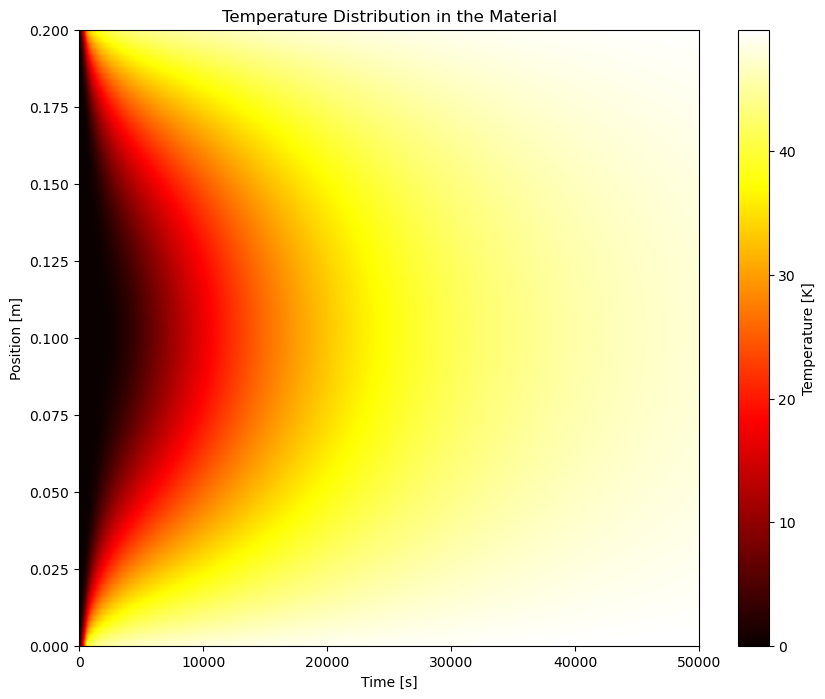

Iter 100, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 200, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 300, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 400, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 500, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 600, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 700, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 800, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 900, Loss: nan, Loss_u: nan, Loss_f: nan
Iter 1000, Loss: nan, Loss_u: nan, Loss_f: nan


KeyboardInterrupt: 

In [28]:
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDAのサポート
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

K = 0.47 #部品の熱伝導率。[W/mK]
rho = 1573 #部品の密度。[kg/m^3]
cp = 967 #部品の比熱。[J/kgK]
alpha = K / (rho * cp)

h1 = 100
h2 = 50
# T_inf = 50

#TODO4：損失関数の重み付け
#lambda0, lambda1, lambda2 = 1.0, 1.0, 1.0 

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# 最優先TODO：初期条件/境界条件の解を計算
x = np.linspace(0, 0.2, 100)[:, None]  # 空間グリッド
t = np.linspace(0, 50000, 10000)[:, None]  # 時間グリッド
dx = x[1] - x[0]  # 空間ステップ
dt = t[1] - t[0]  # 時間ステップ

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    # print(T_ext1, T_ext2)
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    # 境界条件の適用
    # 左端の対流境界条件
    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)

    # 右端の対流境界条件
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)
    # if n % 100 == 0:
    # if n % 60 == 0:
    #     print(t[n])
    #     print(u[n + 1, 0], u[n + 1, 1], u[n + 1, 2], u[n + 1, -3], u[n + 1, -2], u[n + 1, -1])

# 結果のプロット
plt.figure(figsize=(10, 8))
plt.imshow(u.T, extent=[0, 50000, 0, 0.2], aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label='Temperature [K]')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Temperature Distribution in the Material')
plt.show()


X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = u.flatten()[:,None]           

# ドメインの境界
lb = X_star.min(0)
ub = X_star.max(0)    

#xx1は初期時間 (t=0) における全ての空間位置 (x) に対応するデータ
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
#uu1は初期時間 (t=0) における全ての空間位置での温度データ
uu1 = u[0:1,:].T
#xx2は全ての時間における空間位置 (x=0) に対応するデータ
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
#uu2はx=0における全ての時間での温度データ
uu2 = u[:,0:1]
#xx3は全ての時間における空間位置 (x=0.2) に対応するデータ
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
#uu3はx=0.2における全ての時間での温度データ
uu3 = u[:,-1:]

#X_u_train は、初期条件と境界条件に対応するxとtのペアを結合して作成したもの
X_u_train = np.vstack([xx1, xx2, xx3])
#X_f_train は、物理方程式の残差を学習するために使用される
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
#u_train は、X_u_train に対応する温度データ (u)
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

print(X_u_train)
# ネットワーク構造の定義
#TODO1:熱伝達方程式の解に対応したネットワーク構造を定義
#TODO2:対流熱伝達係数を入力に受け取るようにネットワーク構造を変更
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # パラメータ
        self.depth = len(layers) - 1
        
        # レイヤー順序の設定
        self.activation = torch.nn.ELU
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        # レイヤーの展開
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

# 物理インフォームドニューラルネットワーク（PINN）の定義
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, k, rho, cp, alpha, h1, h2):
        
        # 境界条件
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # データ
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.t_inf = torch.where(self.t_u <= 600, 50 * self.t_u / 600, torch.tensor(50.0).to(device))
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        # print(self.x_u.shape, self.t_u.shape, self.x_f.shape, self.t_f.shape, self.u.shape)
        # print(self.t_u)

        self.layers = layers
        
        #新しく追加
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2
        
        # 深層ニューラルネットワーク
        self.dnn = DNN(layers).to(device)
        
        # オプティマイザー: 同じ設定を使用
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    #熱伝導方程式の残差を計算
    def net_f(self, x, t):
        """ PyTorchのautogradを用いて残差を計算 """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - self.alpha * u_xx
        return f
    
    #追加：境界条件の残差①を計算
    def net_BC1(self, x, t):
        """ 境界条件の残差を計算 """
        # T_inf = torch.where(t <= 600, 50 * t / 600, torch.tensor(50.0).to(device))
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        # BC1 = self.T_inf - u + (self.k / self.h1) * u_x
        BC1 = T_inf - u + (self.k / self.h1) * u_x
        return BC1

    #追加：境界条件の残差②を計算
    def net_BC2(self, x, t):
        """ 境界条件の残差を計算 """
        # T_inf = torch.where(t <= 600, 50 * t / 600, torch.tensor(50.0).to(device))
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        # BC2 = self.T_inf - u - (self.k / self.h2) * u_x
        BC2 = T_inf - u - (self.k / self.h2) * u_x
        return BC2
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)

        #追加:境界条件の予測
        BC1_pred = self.net_BC1(self.x_u, self.t_u) # 境界条件1の誤差を計算
        BC2_pred = self.net_BC2(self.x_u, self.t_u) # 境界条件2の誤差を計算

        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        #追加:境界条件の誤差
        loss_BC1 = torch.mean(BC1_pred ** 2)
        loss_BC2 = torch.mean(BC2_pred ** 2)
        
        #TODO3:損失関数のに重み付けを追加
        # loss = (1 / len(f_pred)) * loss_f + self.lambda0 * loss_u + self.lambda1 * loss_BC1 + self.lambda2 * loss_BC2
        loss = loss_u + loss_f + loss_BC1 + loss_BC2
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
        # 逆伝播と最適化
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# モデルのインスタンス化
# model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, rho, cp, k, h1, h2, T_inf)
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, rho, cp, k, h1, h2)

# モデルのトレーニング
# model.train()

# # 予測
# u_pred, f_pred = model.predict(X_star)

# # 誤差の計算
# error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
# print('Error u: %e' % (error_u))                     

# U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
# Error = np.abs(u - U_pred)

# # 可視化
# fig = plt.figure(figsize=(9, 5))
# ax = fig.add_subplot(111)

# h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
#               extent=[t.min(), t.max(), x.min(), x.max()], 
#               origin='lower', aspect='auto')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.10)
# cbar = fig.colorbar(h, cax=cax)
# cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train[:,1], 
#     X_u_train[:,0], 
#     'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
#     markersize = 4, 
#     clip_on = False,
#     alpha=1.0
# )

/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/1186887713.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2
/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/1186887713.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)
/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/1186887713.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you 

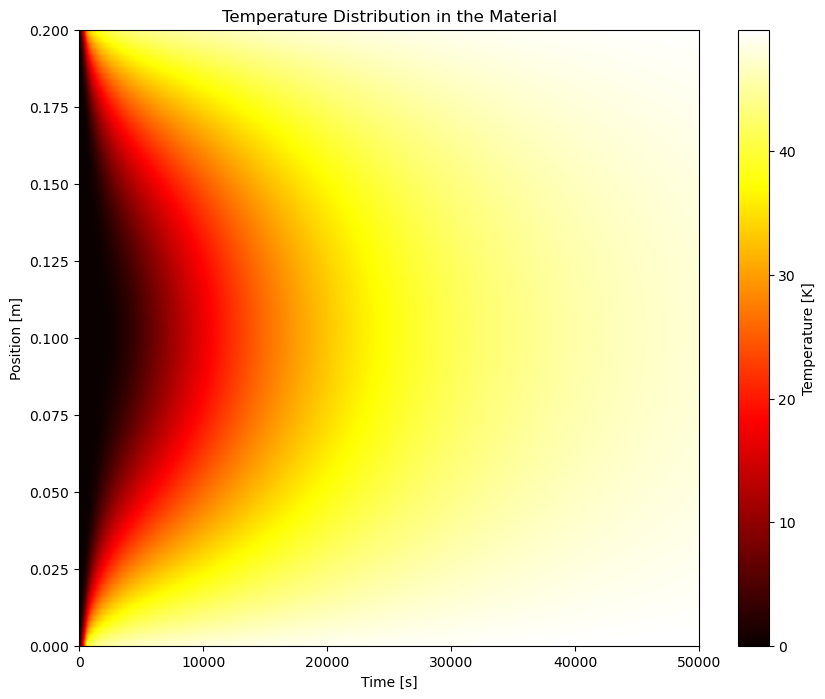

[[0.00000000e+00 1.96969697e+04]
 [0.00000000e+00 3.59335934e+04]
 [0.00000000e+00 2.66426643e+04]
 [2.00000000e-01 1.49914991e+04]
 [0.00000000e+00 4.21892189e+04]
 [2.00000000e-01 3.48034803e+03]
 [2.00000000e-01 4.72647265e+04]
 [2.00000000e-01 1.55765577e+04]
 [0.00000000e+00 1.14561456e+04]
 [0.00000000e+00 2.98279828e+04]
 [2.00000000e-01 3.56485649e+04]
 [0.00000000e+00 4.09540954e+03]
 [0.00000000e+00 2.35523552e+03]
 [2.00000000e-01 4.20142014e+04]
 [2.00000000e-01 1.67166717e+04]
 [2.00000000e-01 3.65586559e+04]
 [0.00000000e+00 2.54625463e+04]
 [0.00000000e+00 3.65736574e+04]
 [2.00000000e-01 1.86968697e+04]
 [0.00000000e+00 4.18691869e+04]
 [0.00000000e+00 4.17941794e+04]
 [2.00000000e-01 9.50095010e+02]
 [2.00000000e-01 1.87618762e+04]
 [0.00000000e+00 2.37373737e+04]
 [1.35353535e-01 0.00000000e+00]
 [0.00000000e+00 8.40084008e+03]
 [2.00000000e-01 1.12061206e+04]
 [2.00000000e-01 4.99949995e+04]
 [2.00000000e-01 3.32283228e+04]
 [0.00000000e+00 2.60526053e+04]
 [0.000000

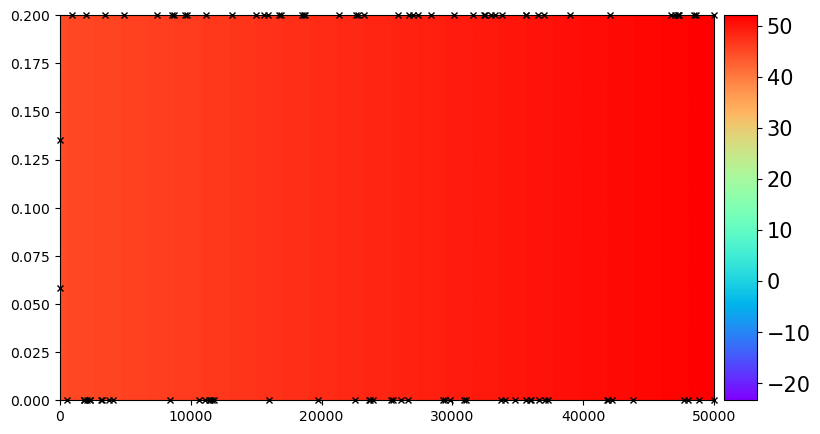

In [30]:

import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDAのサポート
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

K = 0.47 #部品の熱伝導率。[W/mK]
rho = 1573 #部品の密度。[kg/m^3]
cp = 967 #部品の比熱。[J/kgK]
alpha = K / (rho * cp)

h1 = 100
h2 = 50
# T_inf = 50

#TODO4：損失関数の重み付け
#lambda0, lambda1, lambda2 = 1.0, 1.0, 1.0 

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# 最優先TODO：初期条件/境界条件の解を計算
x = np.linspace(0, 0.2, 100)[:, None]  # 空間グリッド
t = np.linspace(0, 50000, 10000)[:, None]  # 時間グリッド
dx = x[1] - x[0]  # 空間ステップ
dt = t[1] - t[0]  # 時間ステップ

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    # print(T_ext1, T_ext2)
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    # 境界条件の適用
    # 左端の対流境界条件
    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)

    # 右端の対流境界条件
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)
    # if n % 100 == 0:
    # if n % 60 == 0:
    #     print(t[n])
    #     print(u[n + 1, 0], u[n + 1, 1], u[n + 1, 2], u[n + 1, -3], u[n + 1, -2], u[n + 1, -1])

# 結果のプロット
plt.figure(figsize=(10, 8))
plt.imshow(u.T, extent=[0, 50000, 0, 0.2], aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label='Temperature [K]')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Temperature Distribution in the Material')
plt.show()


X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = u.flatten()[:,None]           

# ドメインの境界
lb = X_star.min(0)
ub = X_star.max(0)    

#xx1は初期時間 (t=0) における全ての空間位置 (x) に対応するデータ
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
#uu1は初期時間 (t=0) における全ての空間位置での温度データ
uu1 = u[0:1,:].T
#xx2は全ての時間における空間位置 (x=0) に対応するデータ
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
#uu2はx=0における全ての時間での温度データ
uu2 = u[:,0:1]
#xx3は全ての時間における空間位置 (x=0.2) に対応するデータ
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
#uu3はx=0.2における全ての時間での温度データ
uu3 = u[:,-1:]

#X_u_train は、初期条件と境界条件に対応するxとtのペアを結合して作成したもの
X_u_train = np.vstack([xx1, xx2, xx3])
#X_f_train は、物理方程式の残差を学習するために使用される
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
#u_train は、X_u_train に対応する温度データ (u)
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

# ネットワーク構造の定義
#TODO1:熱伝達方程式の解に対応したネットワーク構造を定義
#TODO2:対流熱伝達係数を入力に受け取るようにネットワーク構造を変更
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # パラメータ
        self.depth = len(layers) - 1
        
        # レイヤー順序の設定
        self.activation = torch.nn.ELU
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        # レイヤーの展開
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out


class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, k, rho, cp, alpha, h1, h2):
        # 境界条件
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # データ
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.layers = layers
        
        # 追加：t_infの設定
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2
        
        # 深層ニューラルネットワーク
        self.dnn = DNN(layers).to(device)
        
        # オプティマイザー: 同じ設定を使用
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    def net_t_inf(self, t):
        t_inf = torch.where(t <= 600, 50 * t / 600, torch.tensor(50.0).to(device))
        return t_inf
    
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    # 熱伝導方程式の残差を計算
    def net_f(self, x, t):
        """ PyTorchのautogradを用いて残差を計算 """
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - self.alpha * u_xx
        return f
    
    # 追加：境界条件の残差①を計算
    def net_BC1(self, x, t):
        """ 境界条件の残差を計算 """
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC1 = t_inf - u + (self.k / self.h1) * u_x
        return BC1

    # 追加：境界条件の残差②を計算
    def net_BC2(self, x, t):
        """ 境界条件の残差を計算 """
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC2 = t_inf - u - (self.k / self.h2) * u_x
        return BC2
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)

        # 追加:境界条件の予測
        BC1_pred = self.net_BC1(self.x_u, self.t_u) # 境界条件1の誤差を計算
        BC2_pred = self.net_BC2(self.x_u, self.t_u) # 境界条件2の誤差を計算

        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        # 追加:境界条件の誤差
        loss_BC1 = torch.mean(BC1_pred ** 2)
        loss_BC2 = torch.mean(BC2_pred ** 2)
        
        # TODO3:損失関数のに重み付けを追加
        loss = loss_u + loss_f + loss_BC1 + loss_BC2
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
        # 逆伝播と最適化
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# モデルのインスタンス化
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, k, rho, cp, alpha, h1, h2)

# モデルのトレーニング
model.train()

# 予測
u_pred, f_pred = model.predict(X_star)

# 誤差の計算
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(u - U_pred)

# 可視化
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:, 1], 
    X_u_train[:, 0], 
    'kx', label='Data (%d points)' % (u_train.shape[0]), 
    markersize=4, 
    clip_on=False,
    alpha=1.0
)

plt.show()

/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/725491603.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2
/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/725491603.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)
/var/folders/st/n5b89ytn4b98348x0tqzx3bh0000gn/T/ipykernel_74273/725491603.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you ext

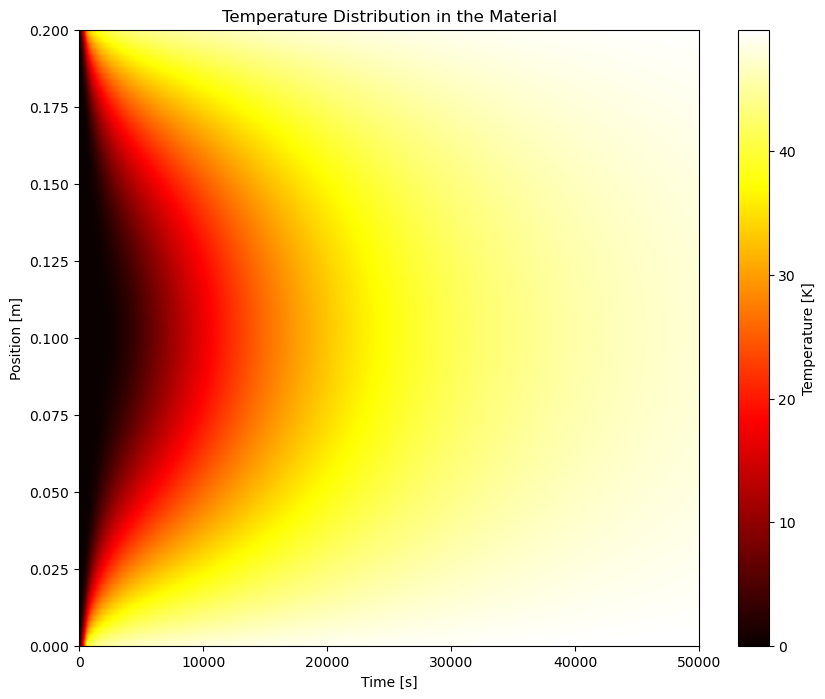

Iter 100, Loss: 5.28645e+02, Loss_u: 1.32807e+02, Loss_f: 5.19454e-02
Error u: 2.738942e-01


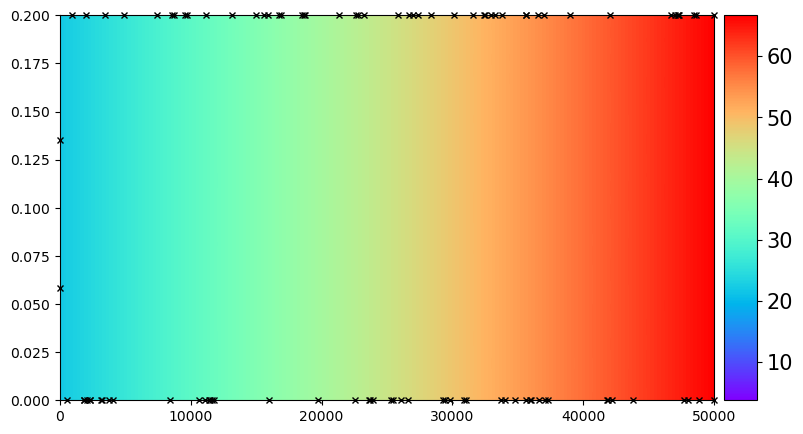

In [32]:
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDAのサポート
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

K = 0.47 #部品の熱伝導率。[W/mK]
rho = 1573 #部品の密度。[kg/m^3]
cp = 967 #部品の比熱。[J/kgK]
alpha = K / (rho * cp)

h1 = 100
h2 = 50
# T_inf = 50

#TODO4：損失関数の重み付け
#lambda0, lambda1, lambda2 = 1.0, 1.0, 1.0 

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# 最優先TODO：初期条件/境界条件の解を計算
x = np.linspace(0, 0.2, 100)[:, None]  # 空間グリッド
t = np.linspace(0, 50000, 10000)[:, None]  # 時間グリッド
dx = x[1] - x[0]  # 空間ステップ
dt = t[1] - t[0]  # 時間ステップ

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    # print(T_ext1, T_ext2)
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    # 境界条件の適用
    # 左端の対流境界条件
    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)

    # 右端の対流境界条件
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)
    # if n % 100 == 0:
    # if n % 60 == 0:
    #     print(t[n])
    #     print(u[n + 1, 0], u[n + 1, 1], u[n + 1, 2], u[n + 1, -3], u[n + 1, -2], u[n + 1, -1])

# 結果のプロット
plt.figure(figsize=(10, 8))
plt.imshow(u.T, extent=[0, 50000, 0, 0.2], aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label='Temperature [K]')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Temperature Distribution in the Material')
plt.show()


X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = u.flatten()[:,None]           

# ドメインの境界
lb = X_star.min(0)
ub = X_star.max(0)    

#xx1は初期時間 (t=0) における全ての空間位置 (x) に対応するデータ
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
#uu1は初期時間 (t=0) における全ての空間位置での温度データ
uu1 = u[0:1,:].T
#xx2は全ての時間における空間位置 (x=0) に対応するデータ
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
#uu2はx=0における全ての時間での温度データ
uu2 = u[:,0:1]
#xx3は全ての時間における空間位置 (x=0.2) に対応するデータ
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
#uu3はx=0.2における全ての時間での温度データ
uu3 = u[:,-1:]

#X_u_train は、初期条件と境界条件に対応するxとtのペアを結合して作成したもの
X_u_train = np.vstack([xx1, xx2, xx3])
#X_f_train は、物理方程式の残差を学習するために使用される
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
#u_train は、X_u_train に対応する温度データ (u)
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

# print(X_u_train)
# ネットワーク構造の定義
#TODO1:熱伝達方程式の解に対応したネットワーク構造を定義
#TODO2:対流熱伝達係数を入力に受け取るようにネットワーク構造を変更
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # パラメータ
        self.depth = len(layers) - 1
        
        # レイヤー順序の設定
        self.activation = torch.nn.ELU
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        # レイヤーの展開
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

# 物理インフォームドニューラルネットワーク（PINN）の定義
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, k, rho, cp, alpha, h1, h2):
        # 境界条件
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # データ
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.layers = layers
        
        # 追加：t_infの設定
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2
        
        # 深層ニューラルネットワーク
        self.dnn = DNN(layers).to(device)
        
        # オプティマイザー: 同じ設定を使用
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    def net_t_inf(self, t):
        t_inf = torch.where(t <= 600, 50 * t / 600, torch.tensor(50.0).to(device))
        return t_inf
    
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    # 熱伝導方程式の残差を計算
    def net_f(self, x, t):
        """ PyTorchのautogradを用いて残差を計算 """
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - self.alpha * u_xx
        return f
    
    # 追加：境界条件の残差①を計算
    def net_BC1(self, x, t):
        """ 境界条件の残差を計算 """
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC1 = t_inf - u + (self.k / self.h1) * u_x
        return BC1

    # 追加：境界条件の残差②を計算
    def net_BC2(self, x, t):
        """ 境界条件の残差を計算 """
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC2 = t_inf - u - (self.k / self.h2) * u_x
        return BC2
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)

        # 追加:境界条件の予測
        BC1_pred = self.net_BC1(self.x_u, self.t_u) # 境界条件1の誤差を計算
        BC2_pred = self.net_BC2(self.x_u, self.t_u) # 境界条件2の誤差を計算

        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        # 追加:境界条件の誤差
        loss_BC1 = torch.mean(BC1_pred ** 2)
        loss_BC2 = torch.mean(BC2_pred ** 2)
        
        # TODO3:損失関数のに重み付けを追加
        loss = loss_u + loss_f + loss_BC1 + loss_BC2
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
        # 逆伝播と最適化
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# モデルのインスタンス化
# model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, rho, cp, k, h1, h2, T_inf)
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, rho, cp, k, h1, h2)

# モデルのトレーニング
model.train()

# 予測
u_pred, f_pred = model.predict(X_star)

# 誤差の計算
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(u - U_pred)

# 可視化
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4, 
    clip_on = False,
    alpha=1.0
)